In [1]:
import networkx as nx
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import pickle
import pandas as pd

from functions import *

In [2]:
PATH = "GoT_files/"

got_graph = pickle.load(open("graphs/dg.pickle", "rb"))
print("Number of nodes:", got_graph.number_of_nodes())
print("Number of edges:", got_graph.number_of_edges())

ep_graph = nx.Graph()
ep_cats = open("categories_for_graphs/episodes.txt", "r").read().splitlines()

got_episode_seasons = [cat.strip("',") for cat in ep_cats if cat.startswith("'Episodes of Game of Thrones")]
hotd_episode_seasons = [cat.strip("',") for cat in ep_cats if cat.startswith("'Episodes of House of the Dragon")]

chars = open("categories_for_graphs/characters.txt", "r").read().splitlines()
chars = [char.strip("',") for char in chars]

lambit_s1 = load_labmit_s1("data/Data_Set_S1.txt")

Number of nodes: 5709
Number of edges: 201180


In [3]:
DG_sections = pickle.load(open("graphs/dg_sections_v2.pickle", "rb"))

for node in list(DG_sections.nodes()):    
    for season in got_episode_seasons:
        if season in DG_sections.nodes[node].get("categories"):
            ep = 'GoT S' + season[-1] + " episode"
            ep_graph.add_node(node, type=ep)
            break
    for season in hotd_episode_seasons:
        if season in DG_sections.nodes[node].get("categories"):
            ep = 'HotD S' + season[-1] + " episode"
            ep_graph.add_node(node, type=ep)
            break

print("Number of nodes:", DG_sections.number_of_nodes())
print("Number of edges:", DG_sections.number_of_edges())

Number of nodes: 5672
Number of edges: 198768


In [4]:
got_s1_char_con_graph = nx.Graph()
got_s2_char_con_graph = nx.Graph()
got_s3_char_con_graph = nx.Graph()
got_s4_char_con_graph = nx.Graph()
got_s5_char_con_graph = nx.Graph()
got_s6_char_con_graph = nx.Graph()
got_s7_char_con_graph = nx.Graph()
got_s8_char_con_graph = nx.Graph()
hotd_s1_char_con_graph = nx.Graph()
hotd_s2_char_con_graph = nx.Graph()

got_char_con_graph = nx.Graph()
hotd_char_con_graph = nx.Graph()

char_con_graphs_list = [got_s1_char_con_graph, got_s2_char_con_graph, got_s3_char_con_graph,
                        got_s4_char_con_graph, got_s5_char_con_graph, got_s6_char_con_graph,
                        got_s7_char_con_graph, got_s8_char_con_graph,
                        hotd_s1_char_con_graph, hotd_s2_char_con_graph]

char_list_graph = pickle.load(open("graphs/dg_characters.pickle", "rb"))

non_names_list = ['Lady', 'Gold', 'Unsullied', 'Sorcerer', 'Blood', 'High', 'Captured', 'Lord', 'White', 'Loyal', 'Elder', 'Winterfell', 'Dragonkeeper', 'Stark', "Ros's", 'Master', 
                  'Despondent', 'Street', 'Dwarf', 'Red', 'Baratheon', 'Faith', 'Wildling', "Drogo's", 'Black', 'Boat', 'Tourney', 'Night', 'Merchant', 'Archmaester', "Night's",
                  'Little', 'Dying', 'Hot', 'Tortured', "Moro's", 'Tyrell', 'Thin', 'Wounded', "Mole's", 'Septon', 'Winter', 'Lannister', 'Singing', 'Silver', "Moro's", 'Great', 'Son',
                  'Valyrian', 'Fighting', "King's", 'Slave', 'Old', "Olly's", 'Frey', "Bastard's", 'Northern', 'Westerosi', 'Citadel', 'Prince', 'Grey', 'Stranger', 'Mother', 'Royal', 
                  'Lead', 'Last', 'Orphan', 'Copper', "Captain's", 'Dothraki', "Yunkai'i", 'Bolton', "Craster's", 'Green', 'Lordsport', 'Ser', 'Farmer', 'Silk', 'Spice', 'Brothel']

In [5]:
description_pattern = r'== ?Synopsis ?==\s*(.*?)\s*==Appearances=='

# Build character co-occurrence graphs for GoT seasons
for season_idx, season_graph in enumerate(char_con_graphs_list[:8]):
    for episode in [episode for episode in ep_graph.nodes() if ep_graph.nodes[episode]['type'] == f"GoT S{season_idx + 1} episode"]:

        ep_text = open(os.path.join(PATH, episode + ".txt"), "r", encoding="utf-8").read()

        m = re.search(description_pattern, ep_text, re.DOTALL)
        if not m:
            continue

        ep_description = m.group(1)
        paragraphs = [p.strip() for p in ep_description.split("\n\n") if p.strip()]

        # ep_description = re.findall(r'== ?Synopsis ?==\s*(.*?)\s*==Appearances==', ep_text, re.DOTALL)
        for paragraph in paragraphs:
            chars_in_paragraph = []
            for character in char_list_graph.nodes():

                char_link = r"\[\[" + re.escape(character) + r"\]\]"

                if not re.search(char_link, ep_description):
                    continue

                char_aliases = [character]
                char_aliases.extend(char_list_graph.nodes[character].get("also_known_as", []))

                first_name = character.split(" ")[0]
                if first_name not in non_names_list and first_name not in char_aliases:
                    if first_name == "Jon" and "Jon Snow" not in char_aliases:
                        continue
                    elif first_name == "Sam" and "Samwell Tarly" not in char_aliases:
                        continue
                    else:
                        char_aliases.append(first_name)

                if any(alias in paragraph for alias in char_aliases):
                    chars_in_paragraph.append(character)
            
            paragraph_tokens = tokenize_text(paragraph, rm_stopwords=True)
            paragraph_sentiment = compute_sentiment(paragraph_tokens, lambit_s1)

            for i in range(len(chars_in_paragraph)):
                for j in range(i + 1, len(chars_in_paragraph)):
                    char_a = chars_in_paragraph[i]
                    char_b = chars_in_paragraph[j]
                    if season_graph.has_edge(char_a, char_b):
                        season_graph[char_a][char_b]['weight'] += 1
                        season_graph[char_a][char_b]['sentiment_scores'].append(paragraph_sentiment)
                    else:
                        season_graph.add_edge(char_a, char_b, weight=1, sentiment_scores=[paragraph_sentiment])
    
    for edge in season_graph.edges():
        season_graph.edges[edge]['average_sentiment'] = np.mean(season_graph.edges[edge]['sentiment_scores'])

    # Save season graph
    pickle.dump(season_graph, open(f'graphs/got_s{season_idx + 1}_char_con_graph.pickle', 'wb'))

In [6]:
for season_idx, season_graph in enumerate(char_con_graphs_list[8:]):
    for episode in [episode for episode in ep_graph.nodes() if ep_graph.nodes[episode]['type'] == f"HotD S{season_idx + 1} episode"]:
        
        ep_text = open(os.path.join(PATH, episode + ".txt"), "r", encoding="utf-8").read()

        m = re.search(description_pattern, ep_text, re.DOTALL)
        if not m:
            continue

        ep_description = m.group(1)
        paragraphs = [p.strip() for p in ep_description.split("\n\n") if p.strip()]

        for paragraph in paragraphs:
            chars_in_paragraph = []
            for character in list(char_list_graph.nodes()):

                char_link = r"\[\[" + re.escape(character) + r"\]\]"

                if not re.search(char_link, ep_description):
                    continue

                char_aliases = [character]
                char_aliases.extend(char_list_graph.nodes[character].get("also_known_as", []))

                first_name = character.split(" ")[0]
                if first_name not in non_names_list and first_name not in char_aliases:
                    char_aliases.append(first_name)

                if any(alias in paragraph for alias in char_aliases):
                    chars_in_paragraph.append(character)

            paragraph_tokens = tokenize_text(paragraph, rm_stopwords=True)
            paragraph_sentiment = compute_sentiment(paragraph_tokens, lambit_s1)

            for i in range(len(chars_in_paragraph)):
                for j in range(i + 1, len(chars_in_paragraph)):
                    char_a = chars_in_paragraph[i]
                    char_b = chars_in_paragraph[j]
                    if season_graph.has_edge(char_a, char_b):
                        season_graph[char_a][char_b]['weight'] += 1
                        season_graph[char_a][char_b]['sentiment_scores'].append(paragraph_sentiment)
                    else:
                        season_graph.add_edge(char_a, char_b, weight=1, sentiment_scores=[paragraph_sentiment])
    
    for edge in season_graph.edges():
        season_graph.edges[edge]['average_sentiment'] = np.mean(season_graph.edges[edge]['sentiment_scores'])

    # Save season graph
    pickle.dump(season_graph, open(f'graphs/hotd_s{season_idx + 1}_char_con_graph.pickle', 'wb'))

In [7]:
# nx.get_edge_attributes(got_s1_char_con_graph, 'sentiment_scores')
# got_s1_char_con_graph.nodes["Jaime Lannister"]

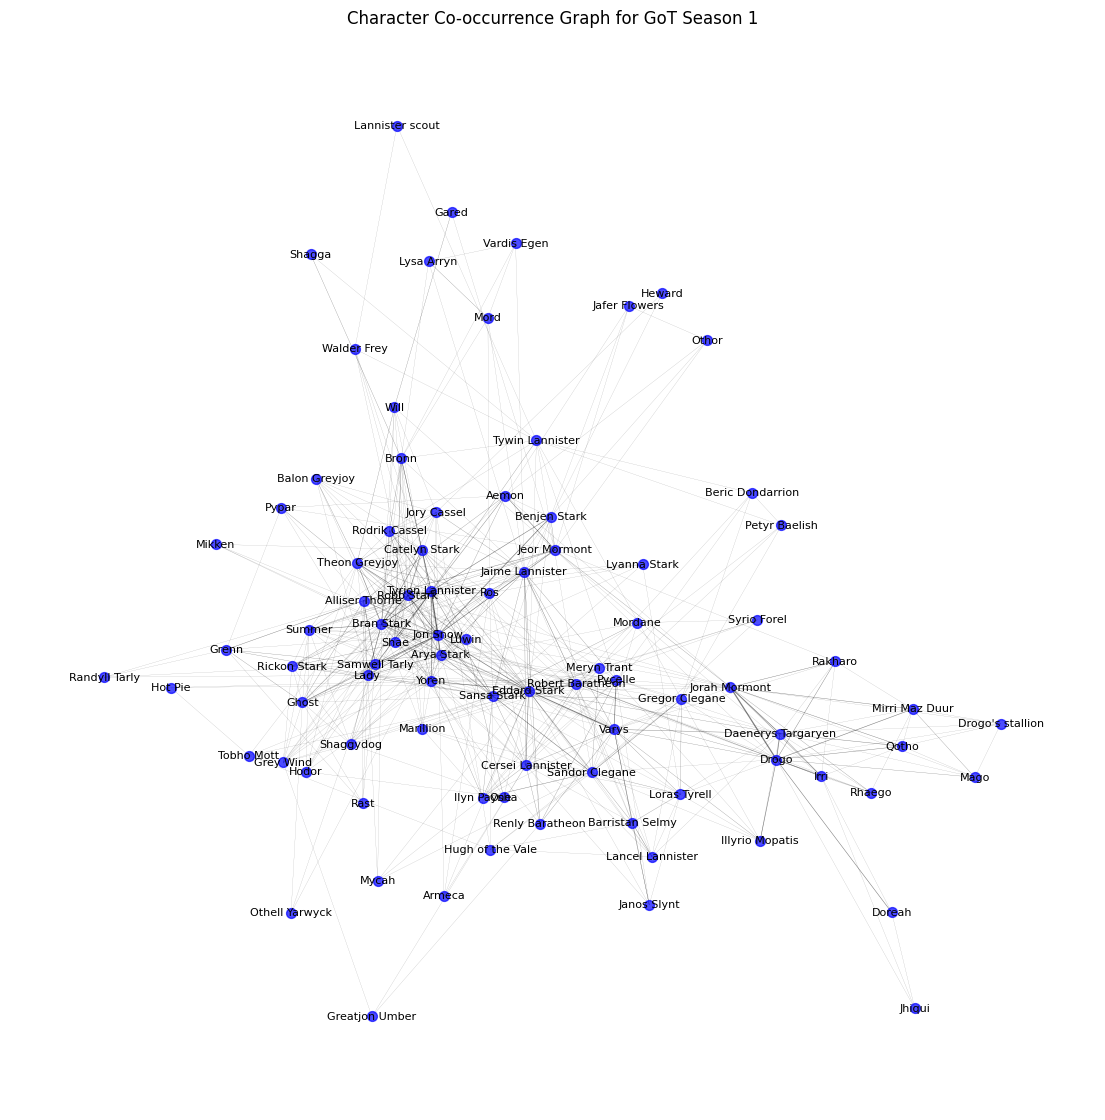

Season 1 - Nodes: 87, Edges: 503
Top 5 characters by degree:
Eddard Stark: 38
Jon Snow: 36
Robb Stark: 30
Tyrion Lannister: 30
Robert Baratheon: 29
Top 5 character pairs by co-occurrence:
Drogo - Jorah Mormont: 9
Tyrion Lannister - Jon Snow: 8
Eddard Stark - Varys: 7
Jon Snow - Bran Stark: 6
Pycelle - Varys: 5
Top 5 character pairs by average sentiment:
Robert Baratheon - Ros: 5.924615384615384
Pycelle - Ros: 5.924615384615384
Drogo - Jhiqui: 5.901351351351352
Irri - Doreah: 5.901351351351352
Irri - Jhiqui: 5.901351351351352
Bottom 5 character pairs by average sentiment:
Jaime Lannister - Barristan Selmy: 4.7755882352941175
Eddard Stark - Mycah: 4.823888888888889
Bran Stark - Mycah: 4.823888888888889
Lady - Mycah: 4.823888888888889
Jaime Lannister - Heward: 4.824571428571429


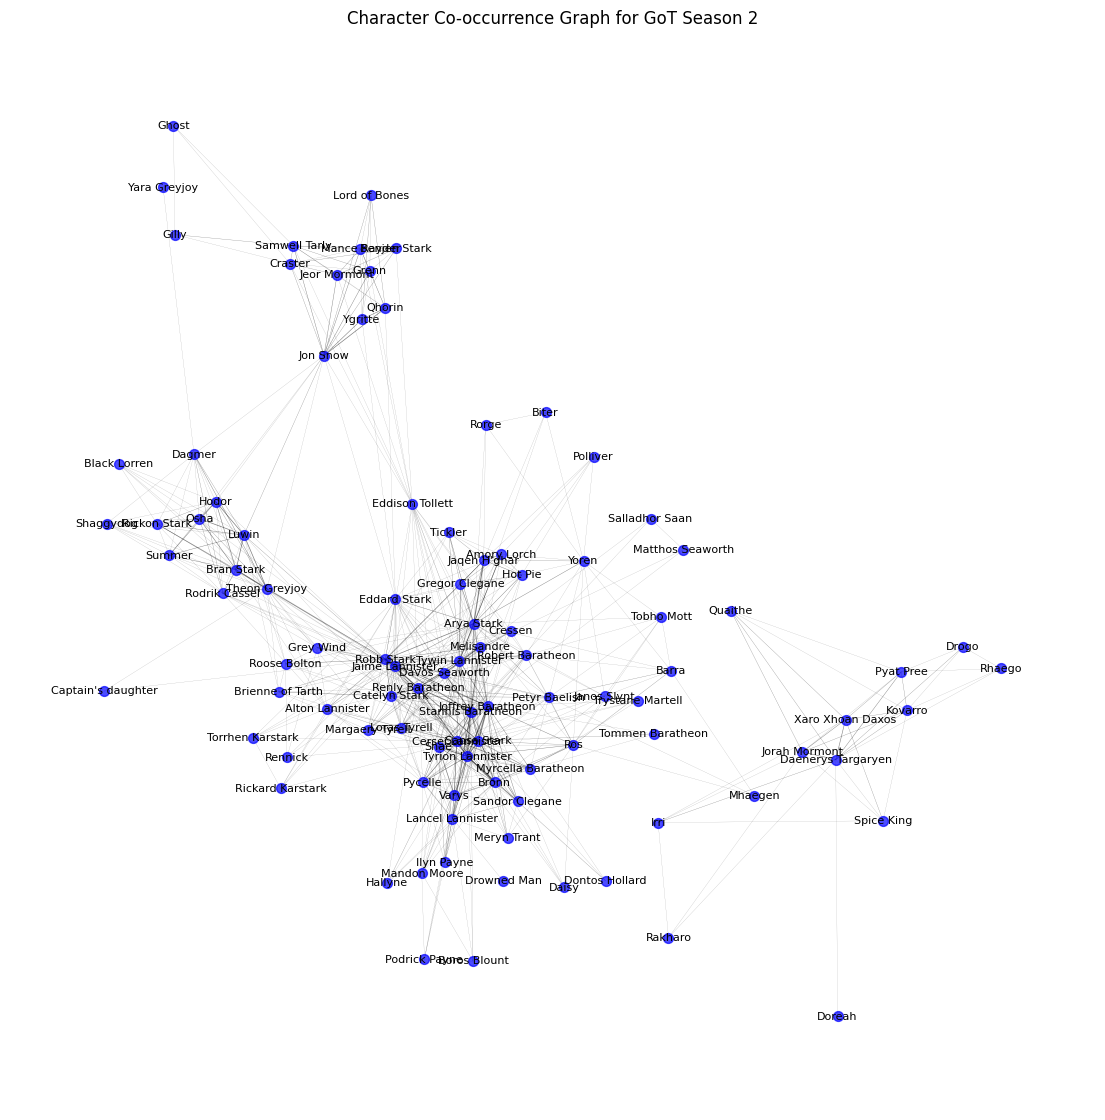

Season 2 - Nodes: 98, Edges: 589
Top 5 characters by degree:
Robb Stark: 45
Stannis Baratheon: 36
Arya Stark: 34
Tyrion Lannister: 34
Joffrey Baratheon: 34
Top 5 character pairs by co-occurrence:
Tyrion Lannister - Bronn: 10
Sansa Stark - Joffrey Baratheon: 9
Arya Stark - Jaqen H'ghar: 8
Tyrion Lannister - Joffrey Baratheon: 8
Tywin Lannister - Arya Stark: 7
Top 5 character pairs by average sentiment:
Stannis Baratheon - Salladhor Saan: 6.31
Stannis Baratheon - Matthos Seaworth: 6.31
Melisandre - Salladhor Saan: 6.31
Melisandre - Matthos Seaworth: 6.31
Salladhor Saan - Matthos Seaworth: 6.31
Bottom 5 character pairs by average sentiment:
Daenerys Targaryen - Rakharo: 4.744705882352941
Jorah Mormont - Irri: 4.744705882352941
Jorah Mormont - Rakharo: 4.744705882352941
Irri - Rakharo: 4.744705882352941
Arya Stark - Polliver: 4.805961538461538


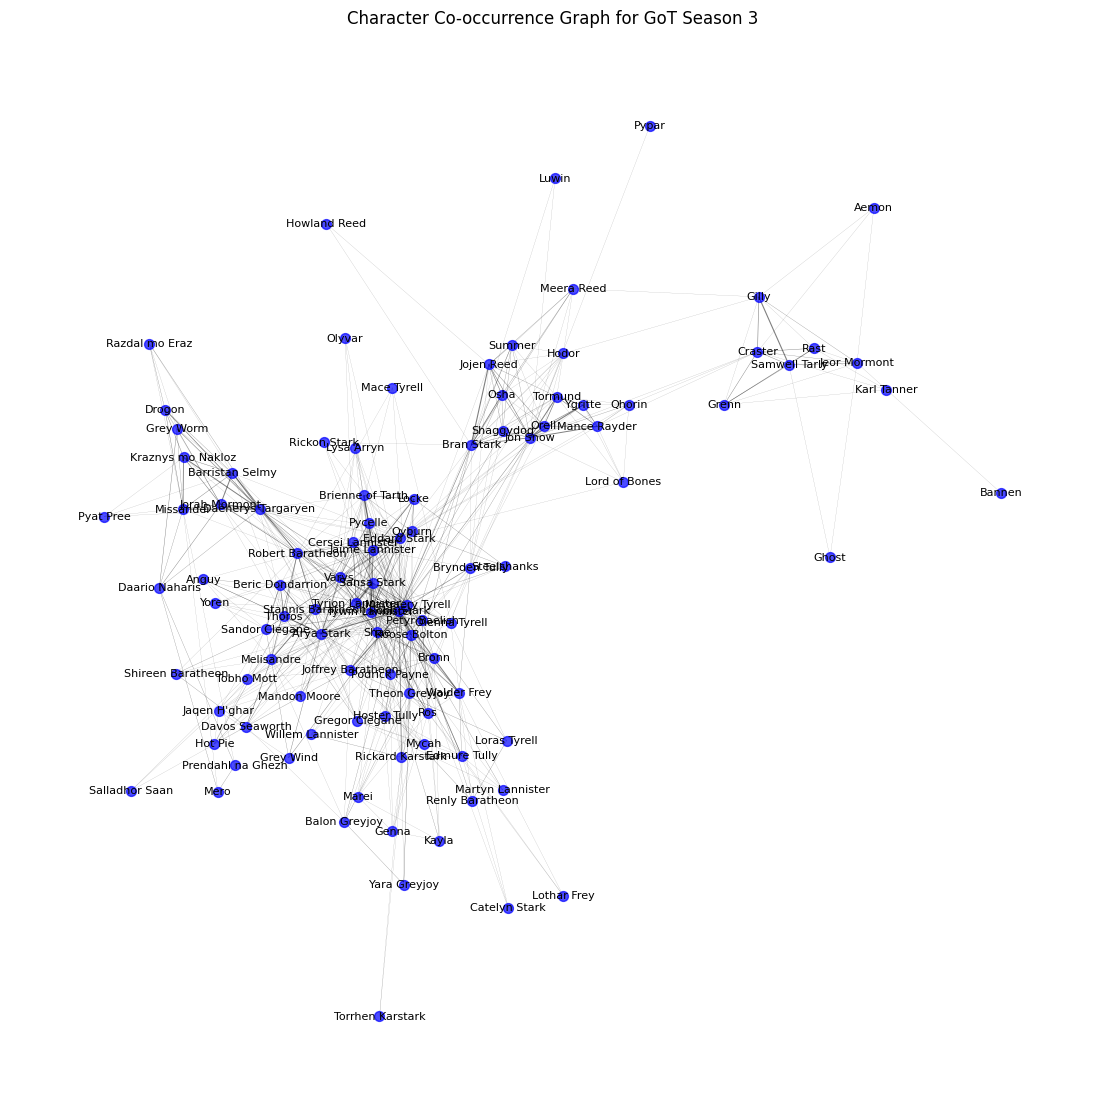

Season 3 - Nodes: 102, Edges: 561
Top 5 characters by degree:
Robb Stark: 52
Tywin Lannister: 35
Arya Stark: 34
Eddard Stark: 30
Varys: 28
Top 5 character pairs by co-occurrence:
Tyrion Lannister - Sansa Stark: 11
Robb Stark - Tywin Lannister: 11
Jaime Lannister - Brienne of Tarth: 9
Tyrion Lannister - Tywin Lannister: 9
Arya Stark - Robb Stark: 8
Top 5 character pairs by average sentiment:
Tyrion Lannister - Roose Bolton: 6.064166666666666
Sansa Stark - Walder Frey: 6.064166666666666
Sansa Stark - Roose Bolton: 6.064166666666666
Sansa Stark - Joffrey Baratheon: 6.060416666666666
Margaery Tyrell - Petyr Baelish: 6.060416666666666
Bottom 5 character pairs by average sentiment:
Rickard Karstark - Willem Lannister: 4.717815249266861
Jaime Lannister - Brynden Tully: 4.749569892473118
Jaime Lannister - Rickard Karstark: 4.749569892473118
Jaime Lannister - Willem Lannister: 4.749569892473118
Robb Stark - Willem Lannister: 4.749569892473118


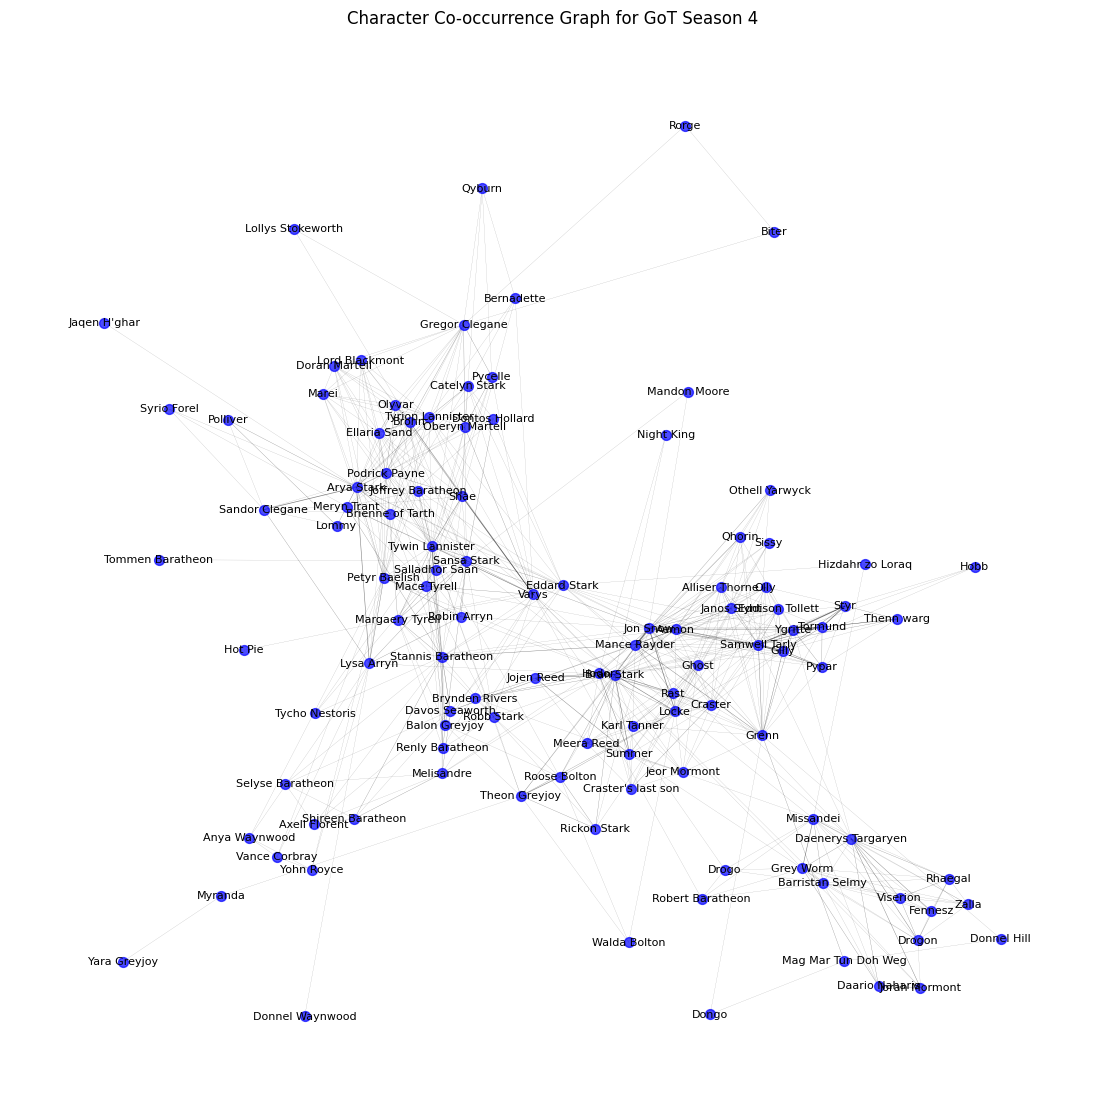

Season 4 - Nodes: 111, Edges: 569
Top 5 characters by degree:
Jon Snow: 33
Bran Stark: 32
Tywin Lannister: 29
Arya Stark: 25
Varys: 24
Top 5 character pairs by co-occurrence:
Tormund - Ygritte: 7
Bran Stark - Hodor: 7
Shae - Varys: 6
Tormund - Styr: 6
Styr - Ygritte: 6
Top 5 character pairs by average sentiment:
Locke - Walda Bolton: 6.038571428571429
Theon Greyjoy - Walda Bolton: 6.038571428571429
Roose Bolton - Walda Bolton: 6.038571428571429
Podrick Payne - Mace Tyrell: 6.020612244897959
Podrick Payne - Margaery Tyrell: 6.020612244897959
Bottom 5 character pairs by average sentiment:
Pypar - Thenn warg: 4.724883720930232
Shae - Meryn Trant: 4.801964285714286
Shae - Stannis Baratheon: 4.801964285714286
Shae - Joffrey Baratheon: 4.801964285714286
Stannis Baratheon - Joffrey Baratheon: 4.801964285714286


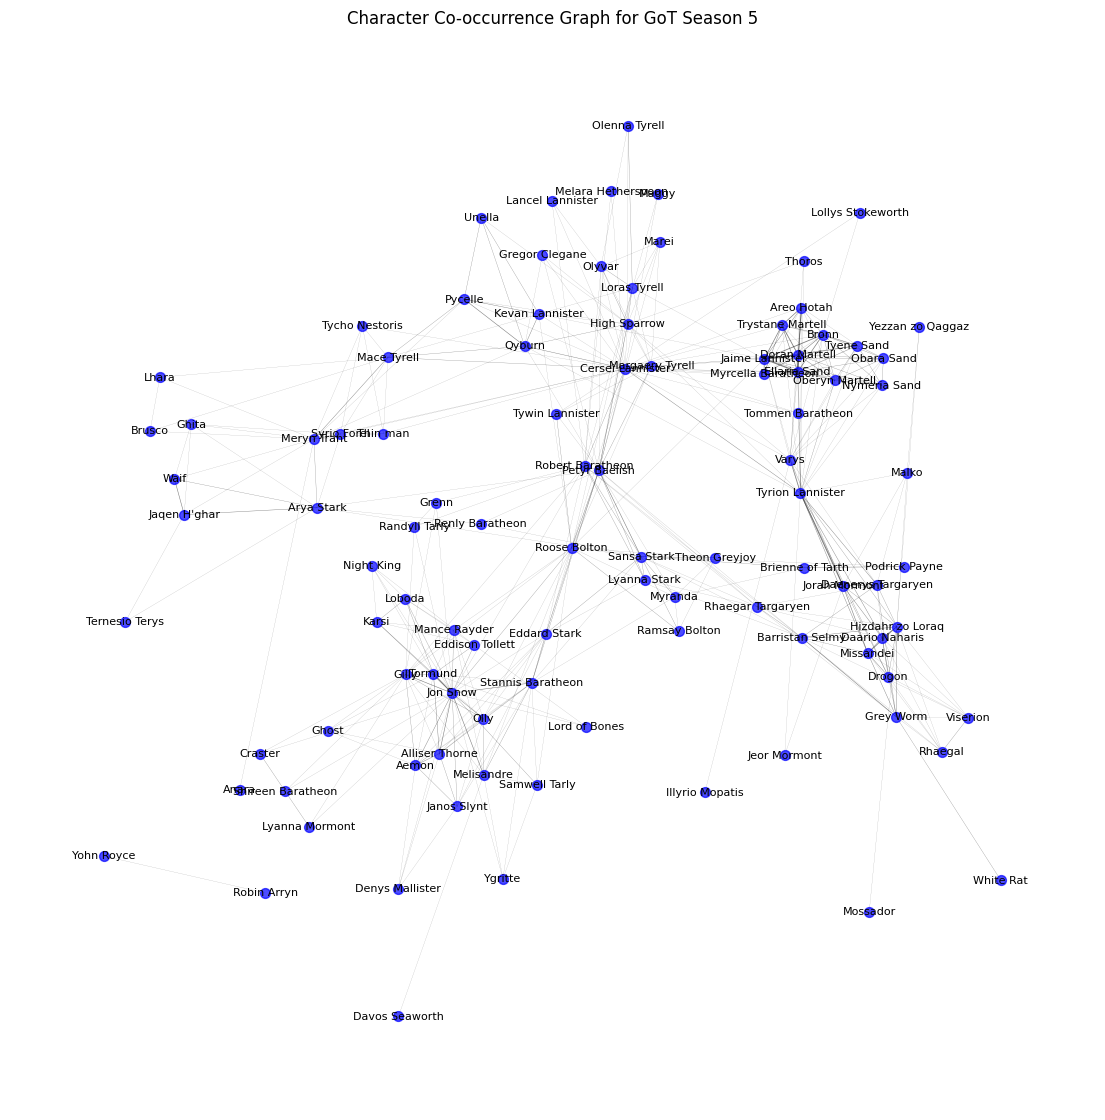

Season 5 - Nodes: 101, Edges: 392
Top 5 characters by degree:
Cersei Lannister: 31
Jon Snow: 25
Tyrion Lannister: 23
Petyr Baelish: 20
Roose Bolton: 18
Top 5 character pairs by co-occurrence:
Ellaria Sand - Doran Martell: 10
Ellaria Sand - Jaime Lannister: 9
Jaime Lannister - Doran Martell: 9
Tyrion Lannister - Jorah Mormont: 8
Tormund - Jon Snow: 7
Top 5 character pairs by average sentiment:
Myrcella Baratheon - Areo Hotah: 6.066296296296296
Tommen Baratheon - Cersei Lannister: 5.907246376811594
Tommen Baratheon - Margaery Tyrell: 5.907246376811594
Meryn Trant - Anara: 5.902666666666667
Cersei Lannister - Lollys Stokeworth: 5.870697674418604
Bottom 5 character pairs by average sentiment:
Cersei Lannister - Tywin Lannister: 4.717894736842105
Cersei Lannister - Roose Bolton: 4.717894736842105
Margaery Tyrell - Tywin Lannister: 4.717894736842105
Margaery Tyrell - Roose Bolton: 4.717894736842105
Petyr Baelish - Tywin Lannister: 4.717894736842105


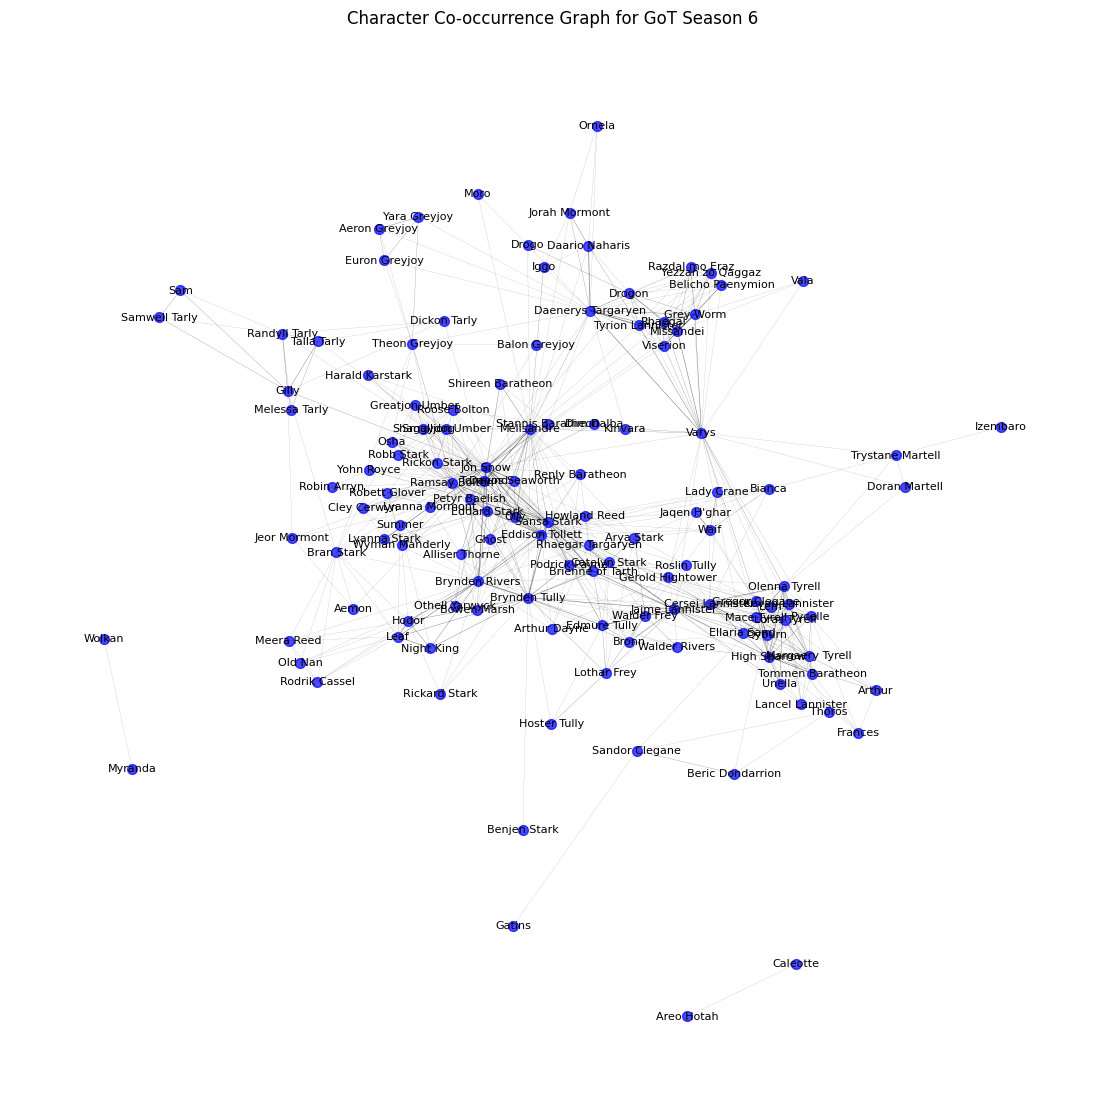

Season 6 - Nodes: 126, Edges: 627
Top 5 characters by degree:
Jon Snow: 47
Sansa Stark: 33
Melisandre: 31
Jaime Lannister: 29
Eddison Tollett: 28
Top 5 character pairs by co-occurrence:
Daenerys Targaryen - Tyrion Lannister: 7
Grey Worm - Missandei: 6
Brynden Tully - Sansa Stark: 6
Brynden Tully - Brynden Rivers: 6
High Sparrow - Margaery Tyrell: 6
Top 5 character pairs by average sentiment:
Randyll Tarly - Samwell Tarly: 6.031000000000001
Randyll Tarly - Sam: 6.031000000000001
Unella - Tommen Baratheon: 5.998222222222223
Unella - Margaery Tyrell: 5.998222222222223
Melisandre - Varys: 5.9876491596638655
Bottom 5 character pairs by average sentiment:
Areo Hotah - Caleotte: 4.757777777777777
Shaggydog - Harald Karstark: 4.943552631578947
Shaggydog - Tormund: 4.943552631578947
Shaggydog - Melisandre: 4.943552631578947
Smalljon Umber - Harald Karstark: 4.943552631578947


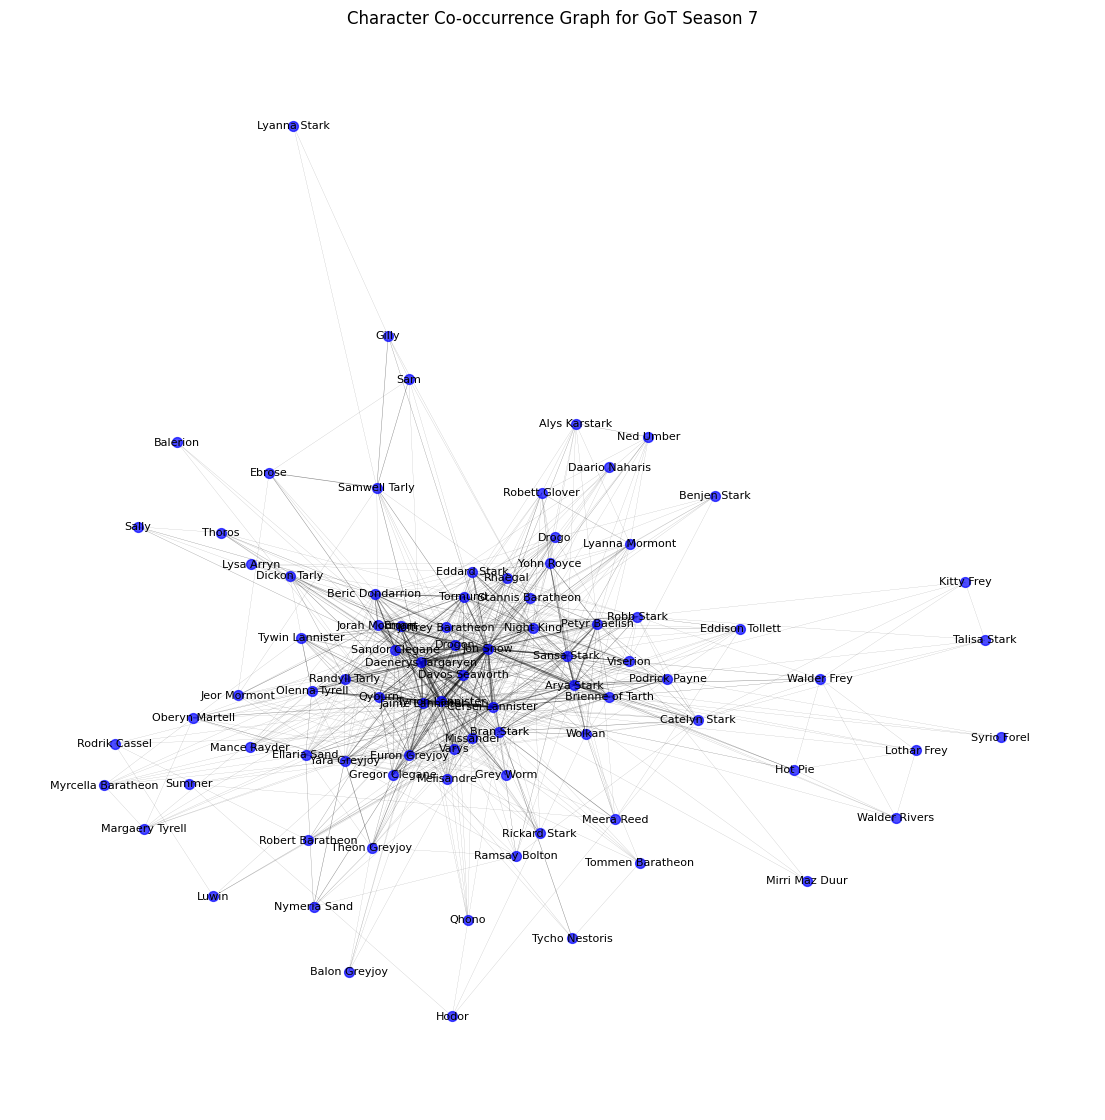

Season 7 - Nodes: 85, Edges: 723
Top 5 characters by degree:
Jon Snow: 60
Cersei Lannister: 57
Tyrion Lannister: 52
Daenerys Targaryen: 51
Jaime Lannister: 37
Top 5 character pairs by co-occurrence:
Jon Snow - Daenerys Targaryen: 20
Daenerys Targaryen - Tyrion Lannister: 19
Jon Snow - Tyrion Lannister: 16
Cersei Lannister - Jon Snow: 14
Cersei Lannister - Tyrion Lannister: 14
Top 5 character pairs by average sentiment:
Arya Stark - Walder Rivers: 6.030666666666667
Arya Stark - Lothar Frey: 6.030666666666667
Cersei Lannister - Walder Frey: 6.030666666666667
Cersei Lannister - Walder Rivers: 6.030666666666667
Cersei Lannister - Lothar Frey: 6.030666666666667
Bottom 5 character pairs by average sentiment:
Cersei Lannister - Balerion: 4.753333333333333
Daenerys Targaryen - Balerion: 4.753333333333333
Qyburn - Balerion: 4.753333333333333
Jaime Lannister - Qhono: 4.760285714285714
Daenerys Targaryen - Qhono: 4.760285714285714


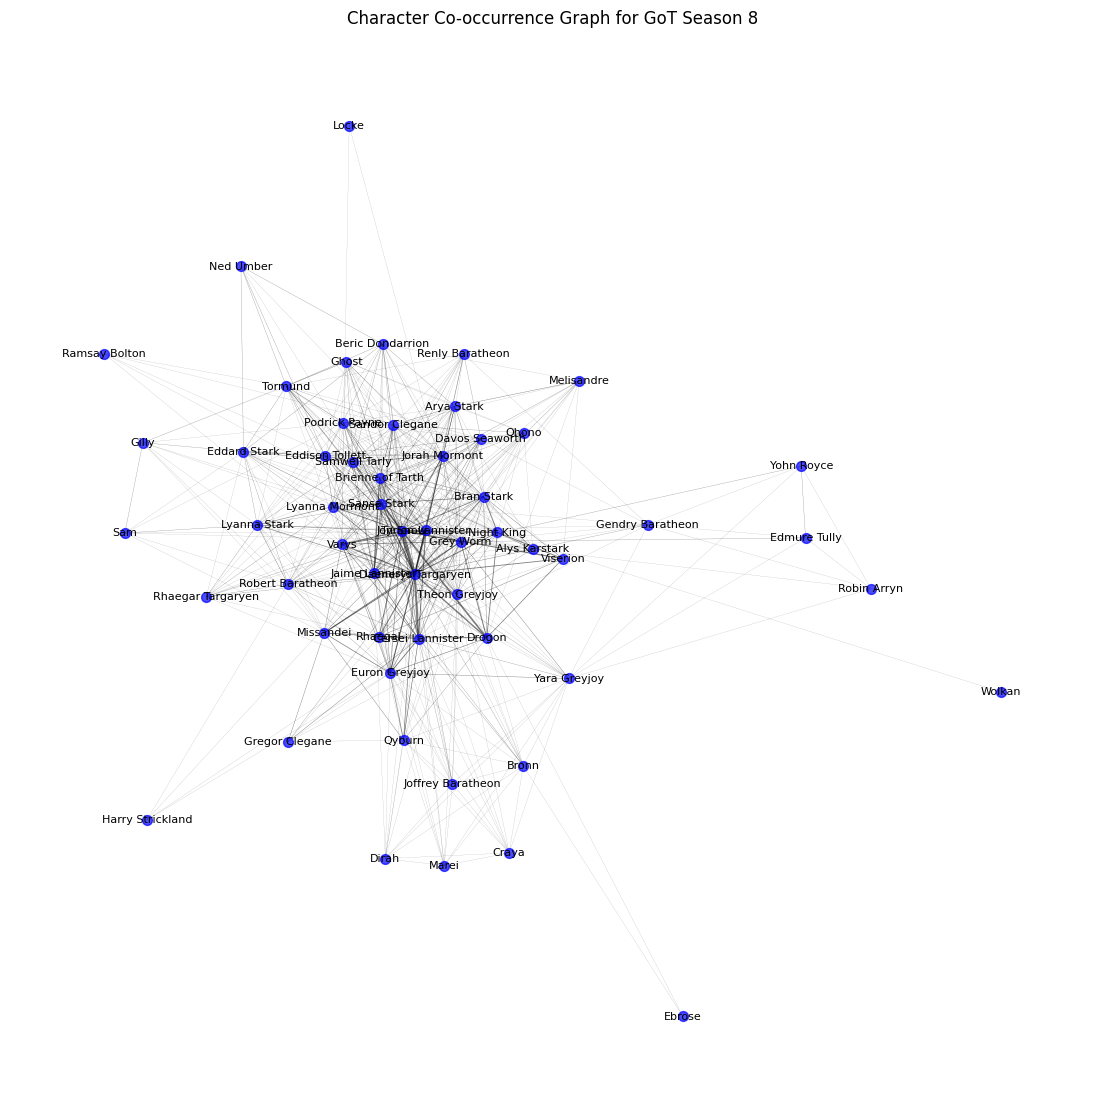

Season 8 - Nodes: 56, Edges: 512
Top 5 characters by degree:
Daenerys Targaryen: 44
Grey Worm: 38
Jon Snow: 38
Tyrion Lannister: 36
Jaime Lannister: 36
Top 5 character pairs by co-occurrence:
Jon Snow - Daenerys Targaryen: 24
Daenerys Targaryen - Cersei Lannister: 14
Daenerys Targaryen - Tyrion Lannister: 14
Jon Snow - Drogon: 12
Drogon - Daenerys Targaryen: 10
Top 5 character pairs by average sentiment:
Podrick Payne - Sansa Stark: 5.794144204851752
Varys - Tormund: 5.784716981132075
Varys - Renly Baratheon: 5.784716981132075
Varys - Podrick Payne: 5.784716981132075
Varys - Davos Seaworth: 5.784716981132075
Bottom 5 character pairs by average sentiment:
Grey Worm - Eddison Tollett: 4.972023070097604
Grey Worm - Samwell Tarly: 4.972023070097604
Drogon - Bran Stark: 4.982832244008715
Tyrion Lannister - Qyburn: 4.985625
Grey Worm - Gregor Clegane: 4.994


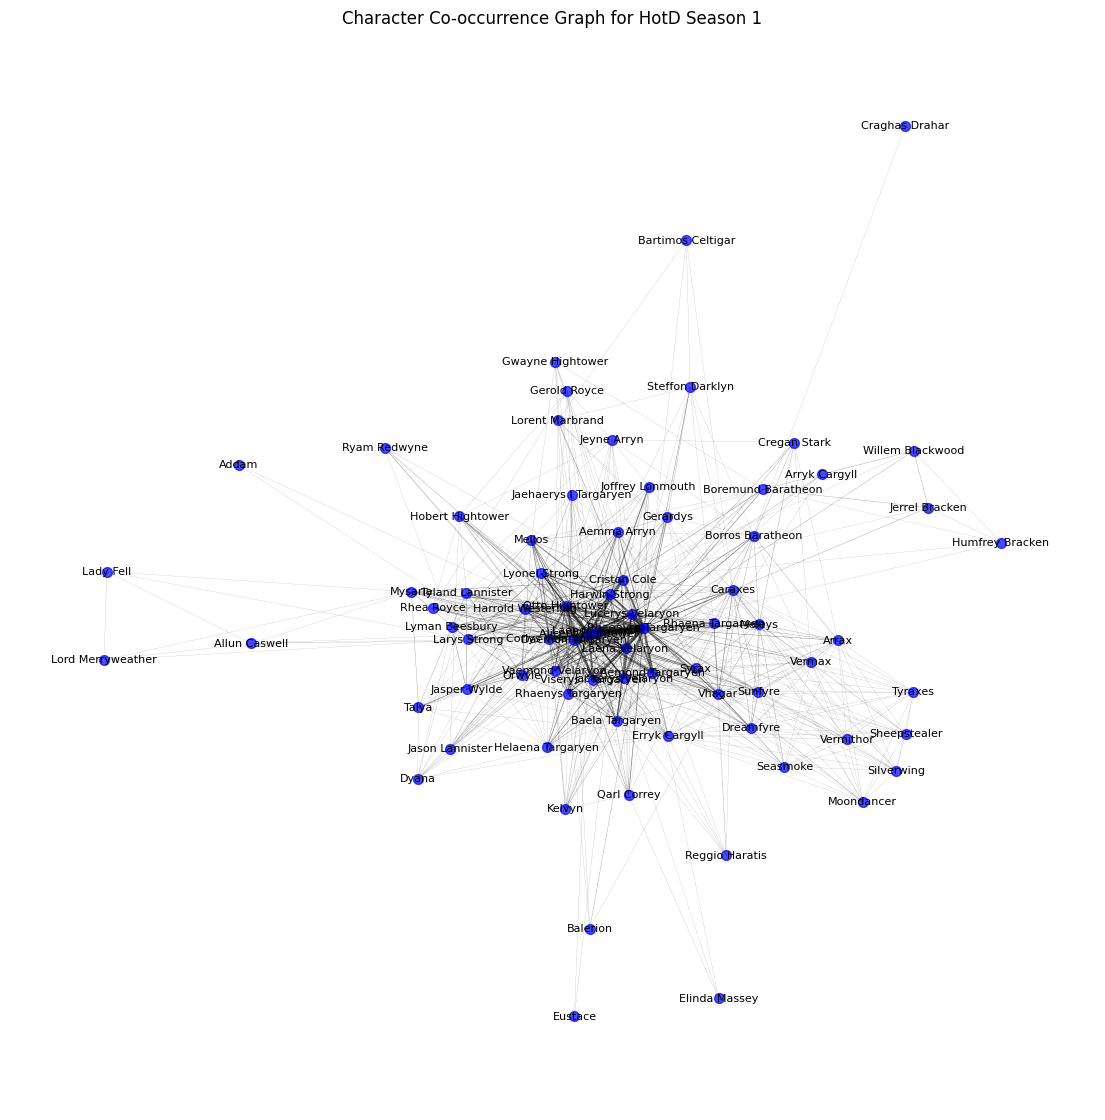

Season 1 - Nodes: 76, Edges: 697
Top 5 characters by degree:
Rhaenyra Targaryen: 66
Alicent Hightower: 51
Daemon Targaryen: 49
Lucerys Velaryon: 42
Corlys Velaryon: 39
Top 5 character pairs by co-occurrence:
Rhaenyra Targaryen - Alicent Hightower: 50
Daemon Targaryen - Rhaenyra Targaryen: 46
Rhaenyra Targaryen - Lucerys Velaryon: 26
Alicent Hightower - Otto Hightower: 26
Daemon Targaryen - Alicent Hightower: 24
Top 5 character pairs by average sentiment:
Laena Velaryon - Joffrey Lonmouth: 6.06506329113924
Otto Hightower - Joffrey Lonmouth: 6.06506329113924
Corlys Velaryon - Joffrey Lonmouth: 6.06506329113924
Harrold Westerling - Joffrey Lonmouth: 6.06506329113924
Daemon Targaryen - Rhaena Targaryen: 6.054693877551021
Bottom 5 character pairs by average sentiment:
Vaemond Velaryon - Seasmoke: 5.052083333333333
Aemond Targaryen - Arrax: 5.082222222222223
Vaemond Velaryon - Laenor Velaryon: 5.116041666666666
Meleys - Lorent Marbrand: 5.117619047619047
Alicent Hightower - Lorent Marbrand: 

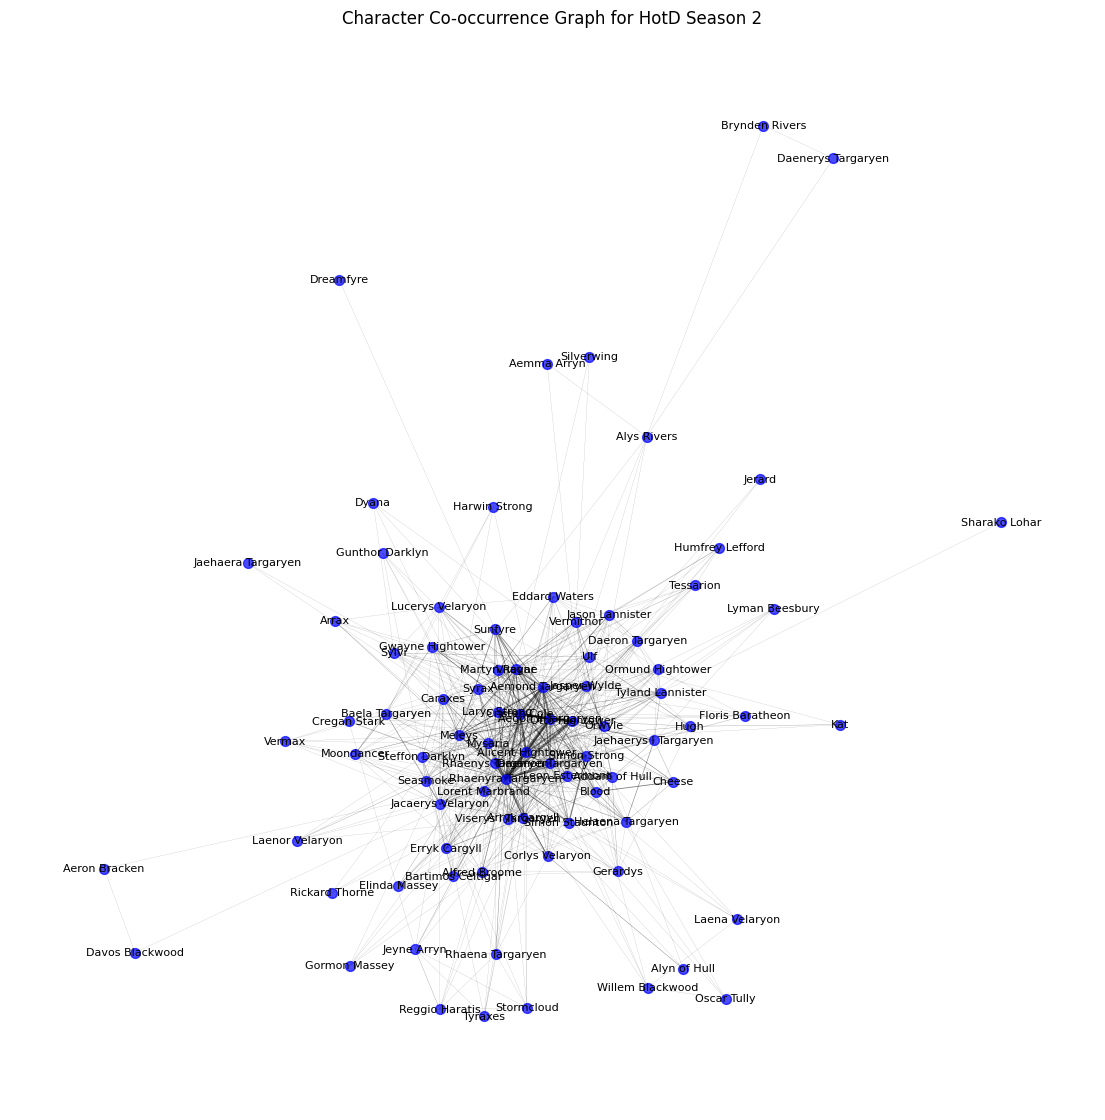

Season 2 - Nodes: 85, Edges: 627
Top 5 characters by degree:
Rhaenyra Targaryen: 61
Criston Cole: 42
Aegon II Targaryen: 41
Aemond Targaryen: 40
Alicent Hightower: 40
Top 5 character pairs by co-occurrence:
Aegon II Targaryen - Rhaenyra Targaryen: 21
Rhaenyra Targaryen - Alicent Hightower: 20
Aegon II Targaryen - Otto Hightower: 19
Aegon II Targaryen - Criston Cole: 17
Rhaenyra Targaryen - Daemon Targaryen: 16
Top 5 character pairs by average sentiment:
Rhaenys Targaryen - Alyn of Hull: 6.02
Aegon II Targaryen - Caraxes: 5.983333333333333
Alys Rivers - Brynden Rivers: 5.978709677419355
Alys Rivers - Daenerys Targaryen: 5.978709677419355
Brynden Rivers - Daenerys Targaryen: 5.978709677419355
Bottom 5 character pairs by average sentiment:
Sunfyre - Dreamfyre: 4.5835
Martyn Reyne - Rickard Thorne: 4.625897435897436
Leon Estermont - Rickard Thorne: 4.625897435897436
Rhaenys Targaryen - Arryk Cargyll: 4.873086419753086
Rhaenys Targaryen - Steffon Darklyn: 4.873086419753086


In [8]:
# Display graphs
for season_idx, season_graph in enumerate(char_con_graphs_list):
    plt.figure(figsize=(14, 14))
    pos = nx.spring_layout(season_graph, k=0.15, iterations=20)
    edges = season_graph.edges()
    weights = [season_graph[u][v]['weight'] for u,v in edges]
    nx.draw_networkx_nodes(season_graph, pos, node_size=50, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(season_graph, pos, edgelist=edges, width=[w * 0.1 for w in weights], alpha=0.5)
    nx.draw_networkx_labels(season_graph, pos, font_size=8)
    if season_idx < 8:
        plt.title(f"Character Co-occurrence Graph for GoT Season {season_idx + 1}")
    else:
        plt.title(f"Character Co-occurrence Graph for HotD Season {season_idx - 7}")
    plt.axis('off')
    plt.show()
    if season_idx < 8:
        print(f"Season {season_idx + 1} - Nodes: {season_graph.number_of_nodes()}, Edges: {season_graph.number_of_edges()}")
    else:
        print(f"Season {season_idx - 7} - Nodes: {season_graph.number_of_nodes()}, Edges: {season_graph.number_of_edges()}")
    # 5 characters with highest degrees
    top_nodes = sorted(season_graph.degree(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 characters by degree:")
    for node, degree in top_nodes:
        print(f"{node}: {degree}")
    # 5 links with highest weights
    top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
    print("Top 5 character pairs by co-occurrence:")
    for u, v, data in top_edges:
        print(f"{u} - {v}: {data['weight']}")
    # 5 links with highest average sentiment
    top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'], reverse=True)[:5]
    print("Top 5 character pairs by average sentiment:")
    for u, v, data in top_edges:
        print(f"{u} - {v}: {data['average_sentiment']}")
    # 5 links with lowest average sentiment
    top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'])[:5]
    print("Bottom 5 character pairs by average sentiment:")
    for u, v, data in top_edges:
        print(f"{u} - {v}: {data['average_sentiment']}")

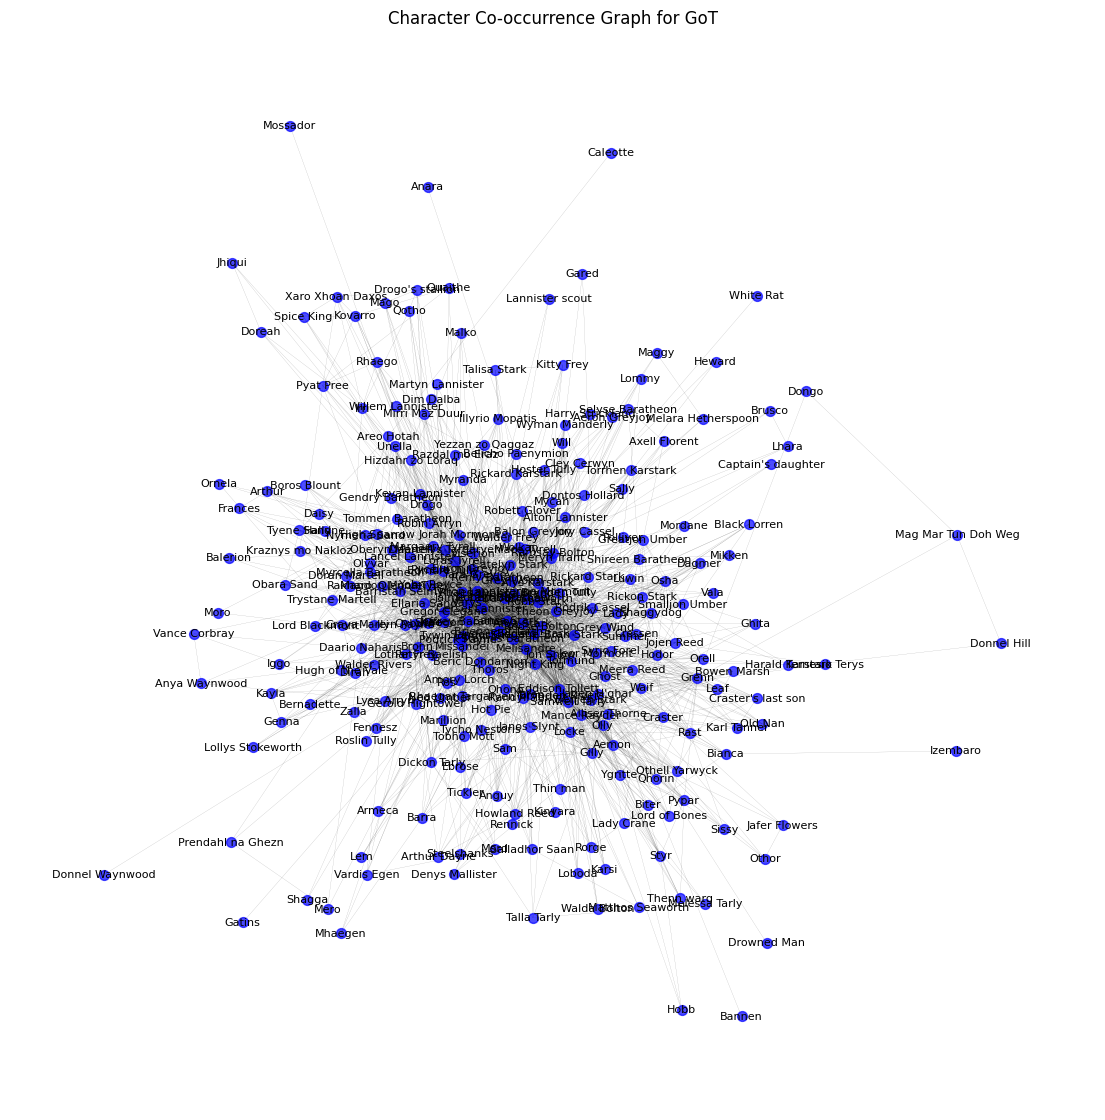

All GoT Seasons Combined - Nodes: 274, Edges: 2878
Top 5 characters by degree:
Jon Snow: 114
Tyrion Lannister: 107
Cersei Lannister: 102
Sansa Stark: 98
Daenerys Targaryen: 97
Top 5 character pairs by co-occurrence:
Jaime Lannister - Robert Baratheon: 1
Jaime Lannister - Vardis Egen: 1
Jaime Lannister - Lysa Arryn: 1
Jaime Lannister - Bronn: 1
Jaime Lannister - Mord: 1
Top 5 character pairs by average sentiment:
Podrick Payne - Sansa Stark: 5.794144204851752
Varys - Tormund: 5.784716981132075
Varys - Renly Baratheon: 5.784716981132075
Varys - Podrick Payne: 5.784716981132075
Varys - Davos Seaworth: 5.784716981132075
Bottom 5 character pairs by average sentiment:
Grey Worm - Eddison Tollett: 4.972023070097604
Grey Worm - Samwell Tarly: 4.972023070097604
Drogon - Bran Stark: 4.982832244008715
Tyrion Lannister - Qyburn: 4.985625
Grey Worm - Gregor Clegane: 4.994


In [9]:
for season_idx, season_graph in enumerate(char_con_graphs_list[:8]):
    for episode in [episode for episode in ep_graph.nodes() if ep_graph.nodes[episode]['type'] == f"GoT S{season_idx + 1} episode"]:

        ep_text = open(os.path.join(PATH, episode + ".txt"), "r", encoding="utf-8").read()

        m = re.search(description_pattern, ep_text, re.DOTALL)
        if not m:
            continue

        ep_description = m.group(1)
        paragraphs = [p.strip() for p in ep_description.split("\n\n") if p.strip()]

        for paragraph in paragraphs:
            chars_in_paragraph = []
            for character in char_list_graph.nodes():

                char_link = r"\[\[" + re.escape(character) + r"\]\]"

                if not re.search(char_link, ep_description):
                    continue

                char_aliases = [character]
                char_aliases.extend(char_list_graph.nodes[character].get("also_known_as", []))

                first_name = character.split(" ")[0]
                if first_name not in non_names_list and first_name not in char_aliases:
                    if first_name == "Jon" and "Jon Snow" not in char_aliases:
                        continue
                    elif first_name == "Sam" and "Samwell Tarly" not in char_aliases:
                        continue
                    else:
                        char_aliases.append(first_name)

                if any(alias in paragraph for alias in char_aliases):
                    chars_in_paragraph.append(character)

            paragraph_tokens = tokenize_text(paragraph, rm_stopwords=True)
            paragraph_sentiment = compute_sentiment(paragraph_tokens, lambit_s1)

            for i in range(len(chars_in_paragraph)):
                for j in range(i + 1, len(chars_in_paragraph)):
                    char_a = chars_in_paragraph[i]
                    char_b = chars_in_paragraph[j]
                    if got_char_con_graph.has_edge(char_a, char_b):
                        got_char_con_graph[char_a][char_b]['sentiment_scores'].append(paragraph_sentiment)
                    else:
                        got_char_con_graph.add_edge(char_a, char_b, weight=1, sentiment_scores=[paragraph_sentiment])

for edge in got_char_con_graph.edges():
    got_char_con_graph.edges[edge]['average_sentiment'] = np.mean(got_char_con_graph.edges[edge]['sentiment_scores'])

# Save character connection graph
pickle.dump(got_char_con_graph, open(f'graphs/got_full_char_con_graph.pickle', 'wb'))

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(got_char_con_graph, k=0.15, iterations=20)
edges = got_char_con_graph.edges()
weights = [got_char_con_graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_nodes(got_char_con_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(got_char_con_graph, pos, edgelist=edges, width=[w * 0.1 for w in weights], alpha=0.5)
nx.draw_networkx_labels(got_char_con_graph, pos, font_size=8)
plt.title(f"Character Co-occurrence Graph for GoT")
plt.axis('off')
plt.show()

print(f"All GoT Seasons Combined - Nodes: {got_char_con_graph.number_of_nodes()}, Edges: {got_char_con_graph.number_of_edges()}")

# 5 characters with highest degrees
top_nodes = sorted(got_char_con_graph.degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 characters by degree:")
for node, degree in top_nodes:
    print(f"{node}: {degree}")
# 5 links with highest weights
top_edges = sorted(got_char_con_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
print("Top 5 character pairs by co-occurrence:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['weight']}")
# 5 links with highest average sentiment
top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'], reverse=True)[:5]
print("Top 5 character pairs by average sentiment:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['average_sentiment']}")
# 5 links with lowest average sentiment
top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'])[:5]
print("Bottom 5 character pairs by average sentiment:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['average_sentiment']}")

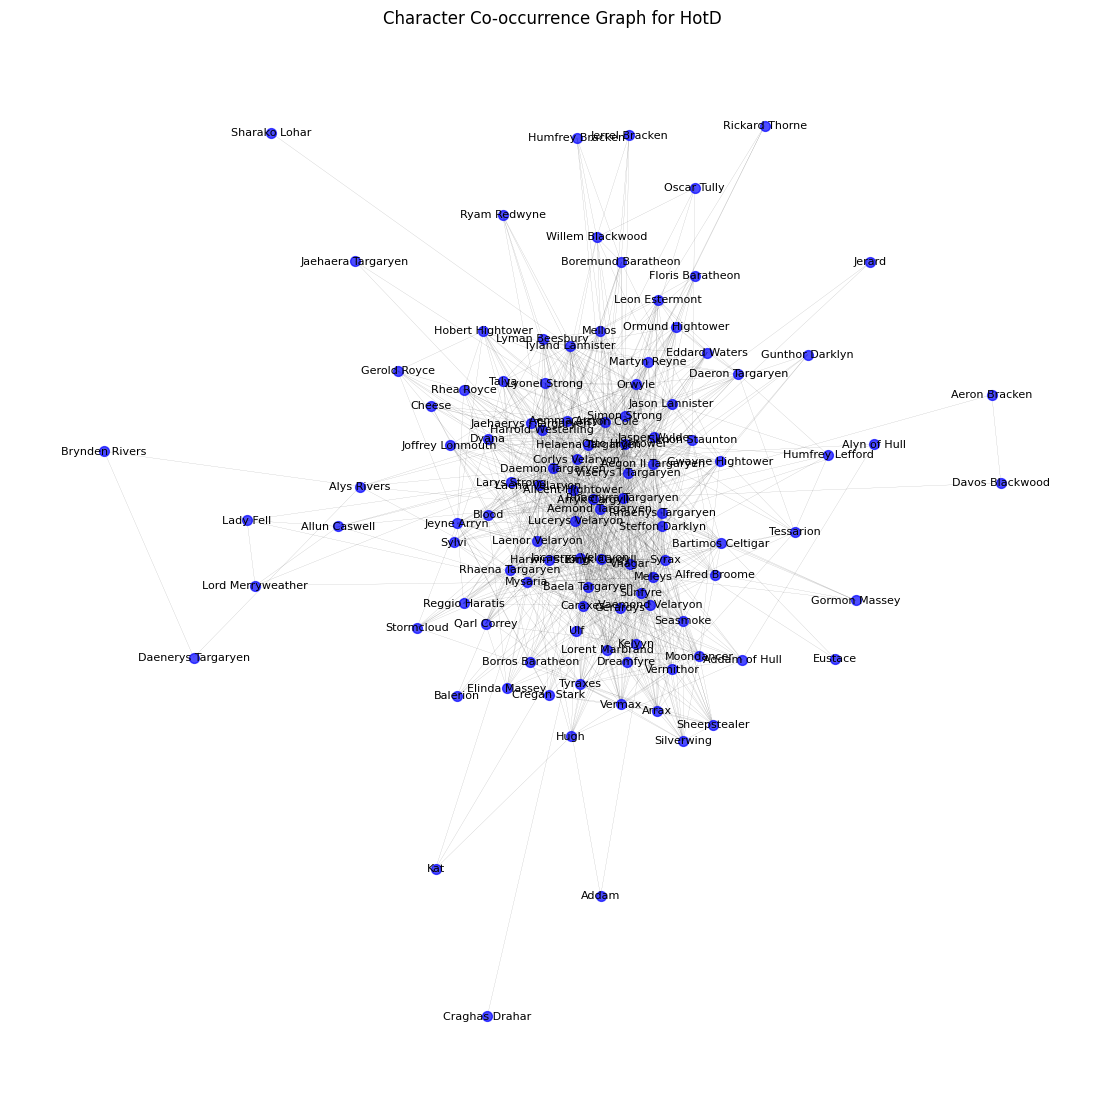

All HotD Seasons Combined - Nodes: 109, Edges: 1130
Top 5 characters by degree:
Rhaenyra Targaryen: 86
Alicent Hightower: 66
Daemon Targaryen: 62
Criston Cole: 61
Otto Hightower: 54
Top 5 character pairs by co-occurrence:
Viserys I Targaryen - Vaemond Velaryon: 1
Viserys I Targaryen - Daemon Targaryen: 1
Viserys I Targaryen - Laena Velaryon: 1
Viserys I Targaryen - Rhaenyra Targaryen: 1
Viserys I Targaryen - Otto Hightower: 1
Top 5 character pairs by average sentiment:
Rhaenys Targaryen - Alyn of Hull: 6.02
Aegon II Targaryen - Caraxes: 5.983333333333333
Alys Rivers - Brynden Rivers: 5.978709677419355
Alys Rivers - Daenerys Targaryen: 5.978709677419355
Brynden Rivers - Daenerys Targaryen: 5.978709677419355
Bottom 5 character pairs by average sentiment:
Sunfyre - Dreamfyre: 4.5835
Martyn Reyne - Rickard Thorne: 4.625897435897436
Leon Estermont - Rickard Thorne: 4.625897435897436
Rhaenys Targaryen - Arryk Cargyll: 4.873086419753086
Rhaenys Targaryen - Steffon Darklyn: 4.873086419753086


In [10]:
for season_idx, season_graph in enumerate(char_con_graphs_list[8:]):
    for episode in [episode for episode in ep_graph.nodes() if ep_graph.nodes[episode]['type'] == f"HotD S{season_idx + 1} episode"]:

        ep_text = open(os.path.join(PATH, episode + ".txt"), "r", encoding="utf-8").read()

        m = re.search(description_pattern, ep_text, re.DOTALL)
        if not m:
            continue

        ep_description = m.group(1)
        paragraphs = [p.strip() for p in ep_description.split("\n\n") if p.strip()]

        for paragraph in paragraphs:
            chars_in_paragraph = []
            for character in char_list_graph.nodes():

                char_link = r"\[\[" + re.escape(character) + r"\]\]"

                if not re.search(char_link, ep_description):
                    continue

                char_aliases = [character]
                char_aliases.extend(char_list_graph.nodes[character].get("also_known_as", []))

                first_name = character.split(" ")[0]
                if first_name not in non_names_list and first_name not in char_aliases:
                    if first_name == "Jon" and "Jon Snow" not in char_aliases:
                        continue
                    elif first_name == "Sam" and "Samwell Tarly" not in char_aliases:
                        continue
                    else:
                        char_aliases.append(first_name)

                if any(alias in paragraph for alias in char_aliases):
                    chars_in_paragraph.append(character)

            paragraph_tokens = tokenize_text(paragraph, rm_stopwords=True)
            paragraph_sentiment = compute_sentiment(paragraph_tokens, lambit_s1)

            for i in range(len(chars_in_paragraph)):
                for j in range(i + 1, len(chars_in_paragraph)):
                    char_a = chars_in_paragraph[i]
                    char_b = chars_in_paragraph[j]
                    if hotd_char_con_graph.has_edge(char_a, char_b):
                        hotd_char_con_graph[char_a][char_b]['sentiment_scores'].append(paragraph_sentiment)
                    else:
                        hotd_char_con_graph.add_edge(char_a, char_b, weight=1, sentiment_scores=[paragraph_sentiment])

for edge in hotd_char_con_graph.edges():
    hotd_char_con_graph.edges[edge]['average_sentiment'] = np.mean(hotd_char_con_graph.edges[edge]['sentiment_scores'])
    
# Save character connection graph
pickle.dump(hotd_char_con_graph, open(f'graphs/hotd_full_char_con_graph.pickle', 'wb'))

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(hotd_char_con_graph, k=0.15, iterations=20)
edges = hotd_char_con_graph.edges()
weights = [hotd_char_con_graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_nodes(hotd_char_con_graph, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(hotd_char_con_graph, pos, edgelist=edges, width=[w * 0.1 for w in weights], alpha=0.5)
nx.draw_networkx_labels(hotd_char_con_graph, pos, font_size=8)
plt.title(f"Character Co-occurrence Graph for HotD")
plt.axis('off')
plt.show()

print(f"All HotD Seasons Combined - Nodes: {hotd_char_con_graph.number_of_nodes()}, Edges: {hotd_char_con_graph.number_of_edges()}")

# 5 characters with highest degrees
top_nodes = sorted(hotd_char_con_graph.degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 characters by degree:")
for node, degree in top_nodes:
    print(f"{node}: {degree}")
# 5 links with highest weights
top_edges = sorted(hotd_char_con_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
print("Top 5 character pairs by co-occurrence:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['weight']}")
# 5 links with highest average sentiment
top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'], reverse=True)[:5]
print("Top 5 character pairs by average sentiment:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['average_sentiment']}")
# 5 links with lowest average sentiment
top_edges = sorted(season_graph.edges(data=True), key=lambda x: x[2]['average_sentiment'])[:5]
print("Bottom 5 character pairs by average sentiment:")
for u, v, data in top_edges:
    print(f"{u} - {v}: {data['average_sentiment']}")